In [3]:
import numpy as np
import h5py

fn = "image1-competition.hdf5"

with h5py.File(fn, "r") as f:
    data = np.array(f["data"])
    wns = np.array(f["wns"])
    tissue_mask = np.array(f["tissue_mask"])
    classes = np.array(f["classes"])

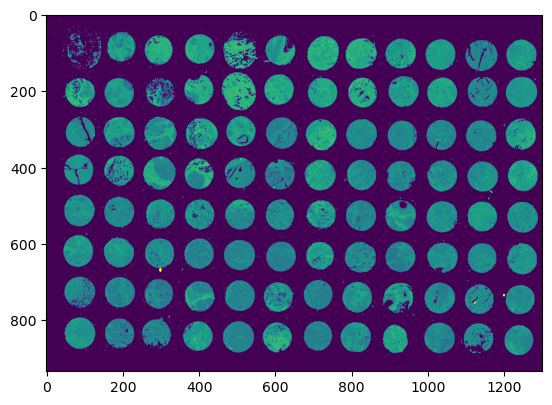

In [4]:
# display the whole image
import matplotlib.pyplot as plt

def nearest_ind(a, v):
    return np.abs(a - v).argmin()

im = data[:, :, nearest_ind(wns, 1560)]
plot = plt.imshow(im, vmin=0, vmax=1)

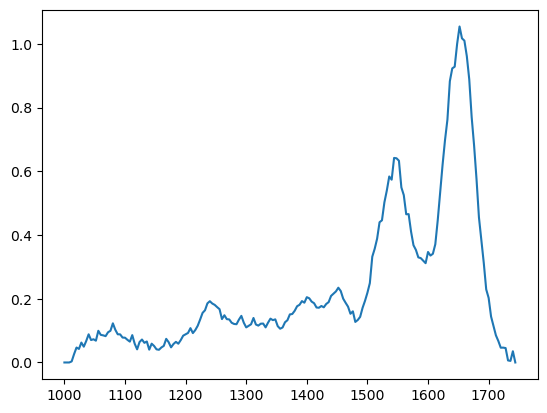

In [5]:
# a single "pixel" is a spectrum
plt.plot(wns, data[110, 220])
plt.show()

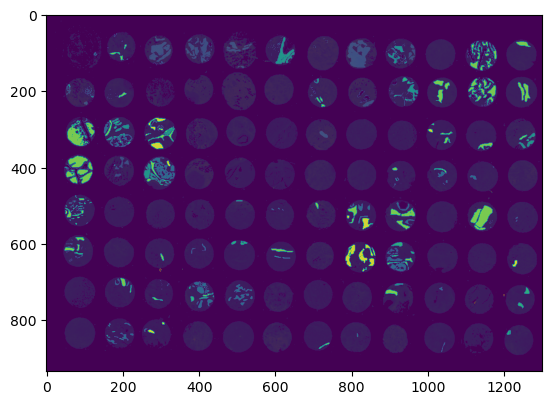

In [6]:
# the classes
plt.imshow(data[:, :, nearest_ind(wns, 1560)], vmin=0, vmax=1)
plt.imshow(classes[:, :], alpha=0.8)

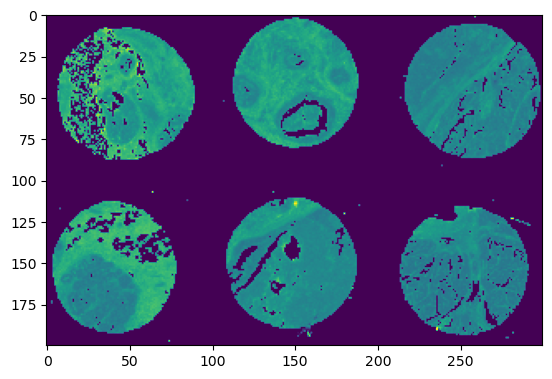

In [7]:
data_predict = data[265:465,360:660]
plt.imshow(data_predict[:, :, nearest_ind(wns, 1560)], vmin=0, vmax=1)

In [8]:
annotated_sel = classes != -1
X = data[annotated_sel]
y = classes[annotated_sel]

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

lr = LogisticRegression(max_iter=10000, C=0.001)
lr.fit(X, y)

LogisticRegression(C=0.001, max_iter=10000)

In [9]:
# take spectra for prediction in a linearized sequence
lin_data_predict = data_predict.reshape(-1, data_predict.shape[-1])
lin_data_predict = scaler.transform(lin_data_predict)

lin_pred = lr.predict_proba(lin_data_predict)
pred = lin_pred.reshape(data_predict.shape[:2] + lin_pred.shape[-1:])

with open("multilogreg.npy", "wb") as f:
    np.save(f, pred.astype(np.float32))


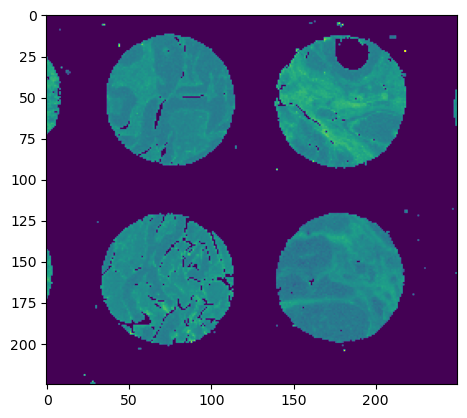

In [10]:
data_val = data[475:700,750:1000]
annotated_sel_val = annotated_sel[475:700,750:1000]
plt.imshow(data_val[:, :, nearest_ind(wns, 1560)], vmin=0, vmax=1)

In [47]:
import torch.nn as nn

n1 = 150

class SpectralMLP(nn.Module):
    def __init__(self, input_features=187, num_classes=3):
        super(SpectralMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_features,n1),
            nn.BatchNorm1d(n1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(n1,15),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(15, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [46]:
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np

np.random.seed(42)
torch.manual_seed(42)

validation = True # Set to False to train on all annotated data without validation

# Create masks
annotated_sel_val = np.zeros_like(annotated_sel, dtype=bool)
annotated_sel_val[475:700, 750:1000] = 1

if validation:
    annotated_train_mask = annotated_sel & ~annotated_sel_val
    annotated_val_mask   = annotated_sel &  annotated_sel_val
else:
    annotated_train_mask = annotated_sel
    annotated_val_mask   = None  # Not used

# Split data
X_train = data[annotated_train_mask]
y_train = classes[annotated_train_mask]

if validation:
    X_val = data[annotated_val_mask]
    y_val = classes[annotated_val_mask]

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
if validation:
    X_val = scaler.transform(X_val)

# Convert to tensors and move to device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
if validation:
    X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val = torch.tensor(y_val, dtype=torch.long).to(device)

# Model, loss, optimizer
model = SpectralMLP(X_train.shape[1], len(np.unique(y_train.cpu().numpy()))).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00) # for mlp lr = 0.0001

# Training loop
epochs = 5500

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train)
    loss = loss_fn(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_loss = loss.item()

    # Validation
    if validation:
        model.eval()
        with torch.inference_mode():
            val_outputs = model(X_val)
            val_loss = loss_fn(val_outputs, y_val).item()
            predictions = torch.argmax(val_outputs, dim=1)
            val_acc = (predictions == y_val).sum().item() / y_val.size(0)

        print(f"Epoch {epoch+1}/{epochs}: Train loss={train_loss:.4f}, Val loss={val_loss:.4f}, Val acc={val_acc:.4f}")
    else:
        print(f"Epoch {epoch+1}/{epochs}: Train loss={train_loss:.4f}")

Using device: cuda
Epoch 1/5500: Train loss=1.8414, Val loss=1.7621, Val acc=0.1716
Epoch 2/5500: Train loss=1.8279, Val loss=1.7594, Val acc=0.1762
Epoch 3/5500: Train loss=1.8239, Val loss=1.7563, Val acc=0.1805
Epoch 4/5500: Train loss=1.8164, Val loss=1.7529, Val acc=0.1874
Epoch 5/5500: Train loss=1.8087, Val loss=1.7494, Val acc=0.1930
Epoch 6/5500: Train loss=1.8039, Val loss=1.7457, Val acc=0.1968
Epoch 7/5500: Train loss=1.7927, Val loss=1.7418, Val acc=0.2045
Epoch 8/5500: Train loss=1.7866, Val loss=1.7379, Val acc=0.2107
Epoch 9/5500: Train loss=1.7795, Val loss=1.7337, Val acc=0.2171
Epoch 10/5500: Train loss=1.7709, Val loss=1.7295, Val acc=0.2255
Epoch 11/5500: Train loss=1.7630, Val loss=1.7251, Val acc=0.2309
Epoch 12/5500: Train loss=1.7561, Val loss=1.7207, Val acc=0.2363
Epoch 13/5500: Train loss=1.7498, Val loss=1.7161, Val acc=0.2419
Epoch 14/5500: Train loss=1.7444, Val loss=1.7115, Val acc=0.2460
Epoch 15/5500: Train loss=1.7373, Val loss=1.7068, Val acc=0.2513


In [35]:
data_predict = data[265:465,360:660]

# take spectra for prediction in a linearized sequence
lin_data_predict = data_predict.reshape(-1, data_predict.shape[-1])
lin_data_predict = scaler.transform(lin_data_predict)

tissue_mask_predict = tissue_mask[265:465,360:660]

lin_data_predict_tensor = torch.tensor(lin_data_predict, dtype=torch.float32).to(device) 

# Predict
model.eval()
with torch.inference_mode():
    pred_logits = model(lin_data_predict_tensor)
    pred_probs = torch.softmax(pred_logits, dim=1) 
    pred_labels = torch.argmax(pred_probs, dim=1)


# Reshape the predicted probabilities to match the data dimensions
pred_probs_reshaped = pred_probs.cpu().numpy().reshape(data_predict.shape[:2] + lin_pred.shape[-1:])
pred_labels_reshaped = pred_labels.cpu().numpy().reshape(data_predict.shape[:2])

background_pred = np.array([0, 1, 0, 0, 0, 0], dtype=pred_probs_reshaped.dtype)

mask_region = ~tissue_mask_predict.astype(bool)
pred_probs_reshaped[mask_region] = background_pred

# Save the probabilities
np.save("basic_prediction_probs.npy", pred_probs_reshaped.astype(np.float32))


In [14]:
# take spectra for prediction in a linearized sequence
lin_data_predict = data_predict.reshape(-1, data_predict.shape[-1])
lin_data_predict = scaler.transform(lin_data_predict)

lin_pred = lr.predict_proba(lin_data_predict)
pred = lin_pred.reshape(data_predict.shape[:2] + lin_pred.shape[-1:])

with open("multilogreg.npy", "wb") as f:
    np.save(f, pred.astype(np.float32))


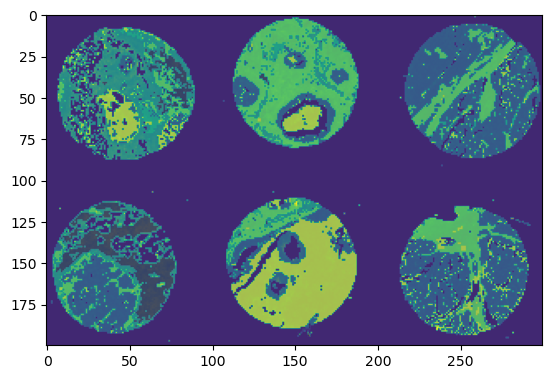

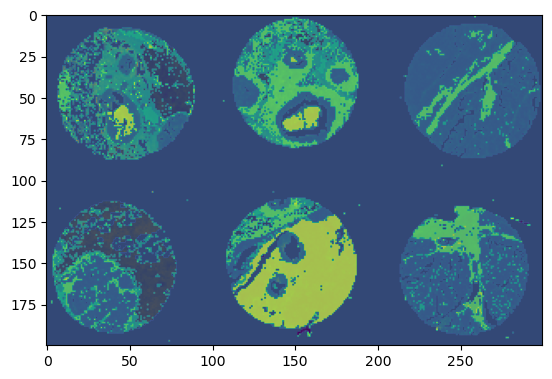

In [15]:
# Get predicted class labels
pred_labels = np.argmax(pred, axis=-1)

# Show the background reflectance map at ~1560nm
plt.imshow(data_predict[:, :, nearest_ind(wns, 1560)], vmin=0, vmax=1)

# Overlay predicted class labels
plt.imshow(pred_labels, alpha=0.6)
plt.show()

# Show a background image: a reflectance map at wavelength nearest to 1560
plt.imshow(data_predict[:, :, nearest_ind(wns, 1560)], vmin=0, vmax=1)

# Overlay the predicted labels (already reshaped)
plt.imshow(pred_labels_reshaped, alpha=0.6) 